## 2.2 Starting From the Basics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_boston
boston = load_boston()
california = fetch_california_housing()

In [2]:
# load data into a dataframe
dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
dataset['target'] = boston.target

In [3]:
# what is the mean of the 506 tracts in Boston?
mean_expected_value = dataset['target'].mean()
mean_expected_value

22.532806324110698

In [4]:
np.mean(dataset['target'])

22.532806324110698

We can now evaluate the results by measuring the error produced in predicting the real y values by this rule. Statistics suggest that, to measure the difference between the prediction and the real value, we should square the differences and then sum them all. This is called the squared sum of errors:

In [5]:
squared_errors = pd.Series(mean_expected_value - dataset['target'])**2

SSE = np.sum(squared_errors)

print ('Sum of squared errors (SSE): %01.f' %SSE)

Sum of squared errors (SSE): 42716


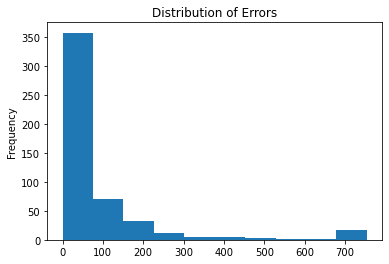

In [6]:
# now we can visualize it as a distribution of errors
density_plot = squared_errors.plot(kind='hist',
                                   title='Distribution of Errors')
density_plot;

Evidently, the mean is not a good representative of certain values, but it is certainly a good baseline to start from. 

### a measure of linear relationship

Correlation helps show what variables may be helpful in predicting a target. But to find correlation you must first standardize a variable

In [7]:
# simple function to standardize a variable
def standardize(x):
    return (x-np.mean(x))/np.std(x)

After standardizing, you compare the squared difference of each variable with its own mean. If the two differences agree in sign, their multiplication will become positive (evidence that they have the same directionality); however, if they differ, the multiplication will turn negative. By summing all the multiplications between the squared differences, and dividing them by the number of observations, you will finally get the correlation which will be a number ranging from -1 to 1.

In [8]:
# Recreates correlation calculation and compares to SciPy
def covariance(variable_1, variable_2, bias=0):
      observations = float(len(variable_1))
      return np.sum((variable_1 - np.mean(variable_1)) * \
      (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
      return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
      return covariance(standardize(var1), standardize(var2),bias)

from scipy.stats.stats import pearsonr
print ('Our correlation estimation: %0.5f' % (correlation(dataset['RM'], dataset['target'])))
print ('Correlation from Scipy pearsonr estimation: %0.5f' % pearsonr(dataset['RM'], dataset['target'])[0])

Our correlation estimation: 0.69536
Correlation from Scipy pearsonr estimation: 0.69536


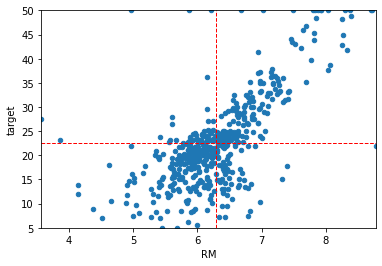

In [9]:
#scatterplots can easily visualize correlations

#Define Ranges for axis based on variable min and max
x_range = [dataset['RM'].min(),dataset['RM'].max()]
y_range = [dataset['target'].min(),dataset['target'].max()]

#create plot
scatter_plot = dataset.plot(kind='scatter', x='RM', y='target',
                           xlim=x_range, ylim=y_range)
meanY = scatter_plot.plot(x_range, [dataset['target'].mean(),
                        dataset['target'].mean()], '--' , 
                        color='red', linewidth=1)
meanX = scatter_plot.plot([dataset['RM'].mean(),dataset['RM'].mean()], 
                          y_range, '--', 
                          color='red', linewidth=1)       

## 2.3 Extending to Linear Regression
Linear regression tries to fit a line through a set of points, choosing the best fit

The best fit is the line that minimizes the sum of squared errors

### Regression with Statsmodels
2 different modules to work out linear regression with statsmodels

- statsmodels.api: This works with distinct predictor and answer variables and requires you to define any transformation of the variables on the predictor variable, including adding the intercept
- statsmodels.formula.api: This works in a similar way to R, allowing you to specify a functional form (the formula of the summation of the predictors)

In [10]:
# Import modules
import statsmodels.api as sm
import statsmodels.formula.api as smf

### using statsmodel.api

In [11]:
#Define X and y variables
y = dataset['target']
X = dataset['RM']
X = sm.add_constant(X)

#set the initialization of the linear regression calculation
linear_regression = sm.OLS(y,X)

#Estimation of the regression coefficients, the B vector
fitted_model = linear_regression.fit()

The X variable needs to be extended by a constant value (); the bias will be calculated accordingly.

In [12]:
X.head()

,const,RM
0,1.0,6.575
1,1.0,6.421
2,1.0,7.185
3,1.0,6.998
4,1.0,7.147


### Using Statsmodel.formula.api

In [13]:
linear_regression = smf.ols(formula='target ~ RM', data=dataset)
fitted_model = linear_regression.fit()

smf.ols expects quite a different input compared to sm.OLS, because it can accept our entire original dataset (it selects what variables are to be used by using the provided formula), whereas sm.OLS expects a matrix containing just the features to be used for prediction. Consequently, some caution has to be exercised when using two such different approaches

In [14]:
#Reset to statsmodel.api module
linear_regression = sm.OLS(y,X)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           2.49e-74
Time:                        15:34:36   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.6706      2.650    -13.084      0.000     -39.877     -29.465
RM             9.1021      0.419     21.722      0.000       8.279       9.925
==============================================================================
Omnibus:                      102.585   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.449
Skew:                           0.726   Prob(JB):                    1.02e-133
Kurtosis:                       8.190   Cond. No.                         58.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Before explaining the outputs above we need to extract the coefficients and the predictions calculated on the data on which the model was built

In [15]:
print(fitted_model.params)
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict(X)

const   -34.670621
RM        9.102109
dtype: float64


### Checking model through residuals

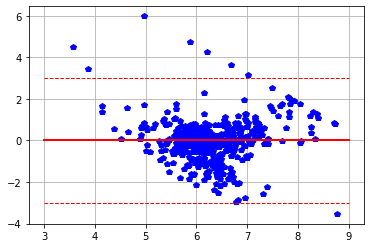

In [16]:
residuals = dataset['target'] - fitted_values
normalized_residuals = standardize(residuals)

residual_scatter_plot = plt.plot(dataset['RM'], normalized_residuals, 'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0], '-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3], '--', color='red', linewidth=1)
plt.grid()

- Residuals are not a random cloud
- there are multiple patterns
- too many residuals lie outside of the normal bounds (-3 or +3)

A nice usage of the predict method is to project the fitted predictions on our previous scatterplot to allow us to visualize the price dynamics in respect of our predictor, the average number of rooms:

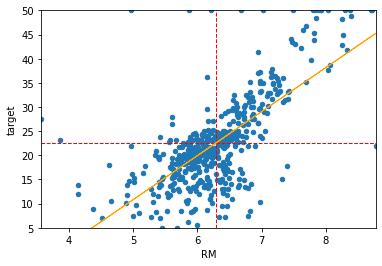

In [18]:
x_range = [dataset['RM'].min(),dataset['RM'].max()]
y_range = [dataset['target'].min(),dataset['target'].max()]
scatter_plot = dataset.plot(kind='scatter', x='RM', y='target', xlim=x_range, ylim=y_range)
meanY = scatter_plot.plot(x_range, [dataset['target'].mean(),dataset['target'].mean()], '--', color='red', linewidth=1)
meanX = scatter_plot.plot([dataset['RM'].mean(),dataset['RM'].mean()], y_range, '--', color='red', linewidth=1)
regression_line = scatter_plot.plot(dataset['RM'], fitted_values, '-', color='orange', linewidth=1)

In [24]:
predictions_by_dot_product = np.dot(X,betas)
print ("Using the prediction method: %s" % fitted_values[:3])
print ("Using betas and a dot product: %s" % predictions_by_dot_product[:3])

Using the prediction method: 0    25.175746
1    23.774021
2    30.728032
dtype: float64
Using betas and a dot product: [25.17574577 23.77402099 30.72803225]


### Regressing with Scikit-learn

In [37]:
from sklearn import linear_model
linear_regression = linear_model.LinearRegression(normalize=False,fit_intercept=True)

Data preparation, instead, requires counting the observations and carefully preparing the predictor array to specify its two dimensions (if left as a vector, the fitting procedure will raise an error):

In [38]:
observations = len(dataset)
X = dataset['RM'].values.reshape((observations,1)) 
# X should be always a matrix, never a vector
y = dataset['target'].values # y can be a vector

After completing all the previous steps, we can fit the model using the fit method:

In [39]:
linear_regression.fit(X,y)

LinearRegression()

In [40]:
print(linear_regression.coef_)
print(linear_regression.intercept_)

[9.10210898]
-34.67062077643857


In [45]:
print(linear_regression.predict(X)[:10])
print(fitted_values[:10])

[25.17574577 23.77402099 30.72803225 29.02593787 30.38215211 23.85593997
 20.05125842 21.50759586 16.5833549  19.97844155]
0    25.175746
1    23.774021
2    30.728032
3    29.025938
4    30.382152
5    23.855940
6    20.051258
7    21.507596
8    16.583355
9    19.978442
dtype: float64


In [53]:
from sklearn.datasets import make_regression
HX, Hy = make_regression(n_samples=1000000, n_features=1, n_targets=1, random_state=101)

In [54]:
%%time
sk_linear_regression = linear_model.LinearRegression(normalize=False,fit_intercept=True)
sk_linear_regression.fit(HX,Hy)

Wall time: 56.9 ms


LinearRegression()

In [55]:
%%time
sm_linear_regression = sm.OLS(Hy,sm.add_constant(HX))
sm_linear_regression.fit()

Wall time: 223 ms


## 2.4 Minimizing the cost function

At the core of linear regression, there is the search for a line's equation that it is able to minimize the sum of the squared errors of the difference between the line's y values and the original ones

### Explaining the reason for using squared errors

- It removes negative values; therefore opposite errors won't reciprocally cancel each other when summed
- It emphasizes larger differences, because as they are squared they will proportionally increase the sum of the errors compared to a simple sum of absolute values

Lets illustrate in Python

In [56]:
x = np.array([9.5, 8.5, 8.0, 7.0, 6.0])
y = np.array([85, 95, 70, 65, 70])

Let's also define a function returning the cost function as squared differences

In [57]:
def squared_cost(v,e):
    return np.sum((v-e)**2)